# XGBoost (2) - SklearnWrapper- 프로젝트에 써보기
- XGBoost 라이브러리를 sklearn과의 호환을 위해 Wrappering한 클래스이다
## 1. 패키지 참조

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import seaborn as sb
from matplotlib import pyplot as plt
from pandas import read_excel

from xgboost import XGBClassifier   # 분류를 위한 클래스; 회귀는 XGBRegressor
from xgboost import plot_importance

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## 2. 데이터 가져오기 및 전처리

In [2]:
origin = read_excel('https://data.hossam.kr/G02/breast_cancer.xlsx')

# 독립/종속 변수 분리
x = origin.drop('target', axis = 1)
y = origin['target']

# 데이터 표준화
std_x = StandardScaler().fit_transform(x)

# 훈련/검증 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(
    std_x, y, test_size = 0.3, random_state=2021
)

# SMOTE 적용
x_sm, y_sm = SMOTE(random_state=2021).fit_resample(x_train, y_train)

x_sm.shape, y_sm.shape, x_test.shape, y_test.shape

((500, 30), (500,), (171, 30), (171,))

## 3. 훈련모델 구현
### 1) XGBoost 전용 데이터 생성 (불필요)
> 기존의 데이터프레임 형식 사용 가능, 그래서 XGBoost(1)과 달리 전용 데이터 생성 불필요

In [3]:
# 불필요
# dtrain = xgb.DMatrix(data=x_sm, label=y_sm, feature_names=list(x.columns))
# dtest = xgb.DMatrix(data=x_test, label=y_test, feature_names=list(x.columns))
# wlist = [(dtrain, 'train'), (dtest, 'eval')] # 리스트로 묶어준다 (데이터셋1, '데이터셋1의_별명'), (데이터셋2, '데이터셋2의_별명')
# wlist

### 2) 학습 모델 적합
- `eta` 파라미터는 `learning_rate`로 이름이 변경된다
- `num_boost_round` 파라미터는 `n_estimator`로 이름이 변경된다
- `sub_sample` 파라미터 -> `subsample`
- `lambda` 파라미터 -> `reg_lambda`
- `alpha` 파라미터 -> `reg_alpha`

In [4]:
xgb_model = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3)
xgb_model.fit(x_sm, y_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### 3) 학습 결과 확인

In [5]:
# 예측치를 산정할 경우 각 클래스에 속할 확률이 아니라 클래스 분류 결과를 반환
preds = xgb_model.predict(x_test)
print('predict( ) 수행 결과값을 10개만 표시, 분류 결과를 표시함')
print(preds[:10])

# 클래스에 속할 확률값 (이진분류이므로 1에 속할 확률만 취함)
pred_probs = xgb_model.predict_proba(x_test)[:, 1]
print('predict_proba( ) 수행 결과값을 10개만 표시, 예측 확률 값을 표시함')
print(pred_probs[:10])

predict( ) 수행 결과값을 10개만 표시, 분류 결과를 표시함
[1 1 1 0 1 0 0 1 0 1]
predict_proba( ) 수행 결과값을 10개만 표시, 예측 확률 값을 표시함
[9.9921024e-01 9.9443418e-01 9.8088878e-01 9.8499935e-04 9.9882632e-01
 1.4456784e-02 1.6132860e-04 9.9923825e-01 8.9017116e-03 9.9996185e-01]


### 4) 성능 평가
#### 1_ 오차 행렬 (Confusion Matrix)

In [6]:
confusion = confusion_matrix(y_test, preds)
confusion

array([[ 60,   4],
       [  3, 104]])

#### 2_ 성능지표 확인

In [7]:
accuracy = accuracy_score(y_test, preds)   # 정확도
precision = precision_score(y_test, preds) # 정밀도
recall = recall_score(y_test, preds)       # 재현율
f1 = f1_score(y_test, preds)               # 
roc_auc = roc_auc_score(y_test, preds)
print ('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

정확도: 0.9591, 정밀도: 0.9630, 재현율: 0.9720, F1: 0.9674, AUC: 0.9547


#### 3_변수 별 중요도 확인 (시각화)

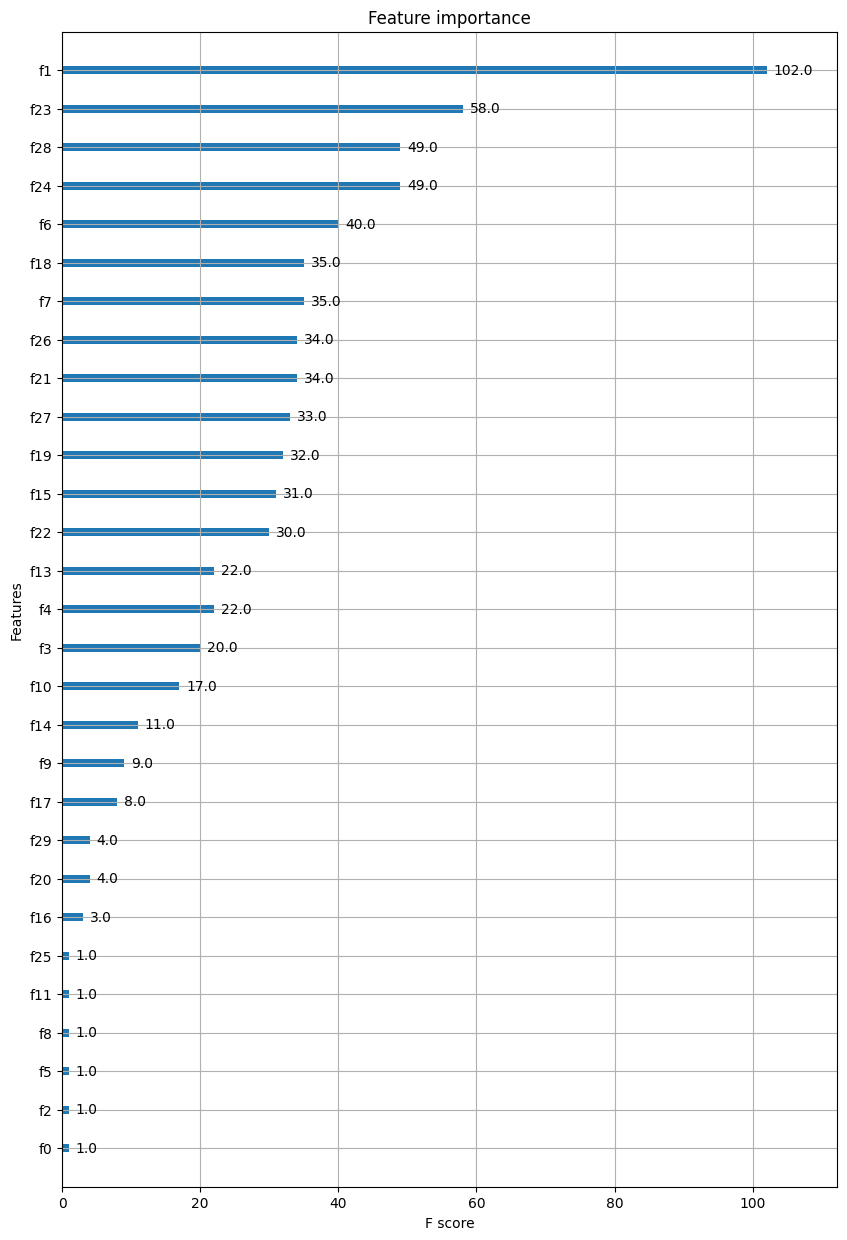

In [8]:
plt.figure(figsize=(10, 15))
plot_importance(xgb_model, ax=plt.gca())
plt.show()
plt.close()

## 4. 하이퍼파라미터 튜닝
- nthread - 기본값 다 씀
### 1) 모델 적합
#### 1_ 주요 일반 파라미터
|파라미터명|설명|
|--|--|
|booster|gbtree(tree based model) 또는 gblinear(linear model) 선택 (기본값 = gbtree)|
|silent|출력 메시지를 나타내고싶지 않을 경우 1 (기본값 = 0)|
|nthread|CPU의 실행 thread 개수를 조정한다 (기본값 = CPU 전체 thread 다 사용); 멀티 코어/스레트 CPU 시스템에서 전체 CPU를 사용하지 않고 일부 CPU만 사용해 ML 애플리케이션을 구동하는 경우에 변경|

#### 2_ 주요 부스터 파라미터
|파라미터명| 설명|
|--|--|
|learning_rate (eta)|학습률; 0 ~ 1 사이의 값을 지정하며 부스팅 스텝을 반복적으로 수행할 때 업데이트 되는 학습률 값; 기본 xgboost를 이용할 경우 (기본값 0.3); sklearn wrapper 클래스를 이용할 경우 eta는 learning_rate 파라미터로 대체된다 (기본값 = 0.1); 보통은 0.01 ~ 0.2 사이의 값을 선호 (xgboost 사용시에도 0.01-0.02를 선호하는가?)|
|n_estimators(num_boost_rounds)|부스팅 반복 횟수|
|min_child_weight|트리에서 추가적으로 가지를 나눌지를 결정하기 위해 필요한 데이터들의 weight 총합, min_child_weight가 클수록 분할을 자제한다; 과적합을 조절하기 위해 사용된다 (기본값 = 1)|
|min_split_losS(gamma)|트리의 리프 노드를 추가적으로 나눌지를 결정할 최소 손실 감소값; 해당 값보다 큰 손실(loss)이 감소된 경우에 리프 노드를 분리한다; 값이 클수록 과적합 감소 효과가 있다 (기본값 = 0)|
|max_depth|트리 기반 알고리즘의 max_depth와 같다; 0을 지정하면 깊이에 제한이 없다; max_depth가 높으면 특정 피쳐 조건에 특화되어 룰 조건이 만들어지므로 과적합 가능성이 높아지며 보통은 3~10 사이의 값을 적용 (기본값 = 6)|
|sub_sample(subsample)|트리가 커져서 과적합되는 것을 제어하기 위해 데이터를 샘플링하는 비율을 지정한다. sub_sample=0.5로 지정하면 전체 데이터의 절반을 트리를 생성하는 데 사용한다. 범위는 0 ~ 1사이의 값이 가능하나 일반적으로 0.5~1 사이의 값을 사용(기본값 = 1)|
|colsample_bytree|GBM의 max_feature와 유사하다. 트리 생성에 필요한 피처 (column)를 임의로 샘플링하는 데 사용된다. 매우 많은 피처가 있는 경우 과적합을 조정하는 데 적용 (기본값 = 1)|

#### 3_ 학습 태스크 파라미터
##### - objective: 최솟값을 가져야 할 손실함수
|함수|설명|
|--|--|
|`binary: logistic`|이진 분류일 때 적용|
|`multi:softmax`|다중 분류일 때 적용; 손실함수가 multi:softmax일 경우 label 클래스의 개수인 num_class parameter를 지정해야 한다|
|`multi:softprob`|multi:softmax와 유사하나 개별 label 클래스의 해당되는 예측 확률을 반환한다|

##### - eval_metric: 검증에 사용되는 함수를 정의한다 
- (기본값 = 회귀인 경우 `rmse`)
- (기본값 = 분류인 결루 `error`))




In [10]:
xgb_model = XGBClassifier()
params = {
    'n_estimators': [300, 400], 
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [5, 7]    
}
grid = GridSearchCV(xgb_model, param_grid = params, scoring='accuracy', cv=5)
grid.fit(x_sm, y_sm)

print(grid.best_params_)
print(grid.best_score_)
best_model = grid.best_estimator_

{'learning_rate': 0.15, 'max_depth': 7, 'n_estimators': 300}
0.9739999999999999


### 2) 과적합 문제가 심각하다면?
- 과적합 문제 혹은 훈련용 데이터의 설명력은 좋으나 검증용 데이터의 설명력이 많이 안 좋을 때, 두 개의 설명력의 값이 차이가 많이 날 때 <해봐야 할 것들>!
1. eta 값을 낮춰본다 (`0.01 ~ 0.1`) 그리고 eta 값을 낮추면 num_round (또는 n_estimator)는 반대로 높여줘야 한다
2. max_depth 값을 낮춰본다
3. min_child_weight 값을 높여본다
4. subsample과 colsample_bytree를 조정하는 것도 트리가 너무 복잡하게 생성되는 것을 막아 과적합 문제에 도움이 될 수 있다